In [1]:
import poliastro as pa

import astropy.units as u
from astropy import time

from poliastro.bodies import Earth, Mars, Sun
from poliastro.twobody import Orbit

from poliastro.plotting import OrbitPlotter3D

import numpy as np

In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
from astropy.coordinates import solar_system_ephemeris
solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [18]:
class Env():
    def __init__(self):
        
        self.nond_l = (1*u.AU).decompose()
        self.nond_v = ((Sun.k/self.nond_l)**0.5).decompose()
        self.nond_t = (self.nond_l/self.nond_v).decompose()
        
        self.nond_m = 525.2*u.kg
        self.T_max = 2*u.N
        self.c = 2500*10*u.m/u.s
        
        self.accel_factor = ((self.T_max*self.nond_t)/(self.nond_m*self.nond_v)).decompose().value
        self.mdot_factor = ((self.T_max*self.nond_t)/(self.nond_m*self.c)).decompose().value
        
        self.dt = ((15*u.day)/self.nond_t).decompose().value
        
        self.target_time = 302*u.day
    
    def get_final_loc(self, tof):
        
        date = self.t_ref + tof*self.nond_t
        
        ss_mars  = Orbit.from_body_ephem(Mars, date)
        
        r1, v1 = ss_mars.rv()
        
        r1 = (r1/self.nond_l).decompose().value
        v1 = (v1/self.nond_v).decompose().value
        
        return r1, v1
    
    def reset(self):
        
        date_launch = time.Time(2454396.30662312, format='jd') #used in linares paper
        
        self.t_ref = date_launch
        
        #todo: if we change the t_ref and date_launch, we need to update this.
        tof = 0. #((date_launch - self.t_ref)/self.nond_t).decompose().value #non dimensional flight time elapsed
        
        
        ss_earth = Orbit.from_body_ephem(Earth, date_launch)
        ss_mars  = Orbit.from_body_ephem(Mars,  date_launch)

        r0, v0 = ss_earth.rv()
        r1, v1 = ss_mars.rv()
        
        r0 = (r0/self.nond_l).decompose().value
        v0 = (v0/self.nond_v).decompose().value
        
        r1 = (r1/self.nond_l).decompose().value
        v1 = (v1/self.nond_v).decompose().value
        
        m0 = 1.
        
        state = np.array(r0)
        state = np.append(state, v0)
        state = np.append(state, m0)
        state = np.append(state, r1-r0)
        state = np.append(state, v1-v0)
        state = np.append(state, tof)
        
        env.state = state
        
        return state
    
    def step(self, thrust):
        
        done = False
        info =  None
        
        state = env.state
        
        r0  = state[:3]
        v0  = state[3:6]
        m0  = state[6]
        rd  = state[7:10]
        vd  = state[10:13]
        tof = state[13]
        
        
        
        # action represents the thrust in the three directions (non-dimensionalized)
        
        
        
        # ---- dynamics
        
        #dt = self.dt/100
        
        #a = (thrust/m0)*self.accel_factor
        
        #hack to allow for finer time steps in simulation
        #for _ in range(100):
          #  r0dot = v0
         #   v0dot = a - r0*np.linalg.norm(r0)**-3
           # mdot  = -np.linalg.norm(thrust)*self.mdot_factor


            #r0 = r0 + r0dot*dt
            #v0 = v0 + v0dot*dt
           # m0 = m0 + mdot*dt
           # tof = tof + dt
        
        #dt = self.dt
        def create_ad(thrust, m):
            # take in nond-thrust and nond-m
            # return dimensional acceleration
            accel_km_ss = ((thrust*self.T_max)/(m*self.nond_m)).to(u.km/u.s**2).value
            
            def ad(t0, u_, k_):
                return accel_km_ss
            
            return ad
        
        ad = create_ad(thrust, m0)
        
        tofs = [self.dt]*env.nond_t
        
        r0s, v0s = pa.twobody.propagation.cowell(Sun.k, r=s[:3]*env.nond_l, v=s[3:6]*env.nond_v, tofs=tofs, ad=ad)
        
        r0 = (r0s[0]/self.nond_l).decompose().value
        v0 = (v0s[0]/self.nond_v).decompose().value
        
        tof = tof + self.dt
        
        r1, v1 = self.get_final_loc(tof)
        
        #return [new_r0, new_v0, [new_m0], new_r1-new_r0, new_v1 - new_v0, [new_tof]]
        
        new_state = np.concatenate([r0, v0, [m0], r1-r0, v1 - v0, [tof]])
        
        env.state = new_state
        
        #compute rewards
        
        c1, c2, c3, c4, c5, c6 = 0.5, -500, -0.05, -500, 0.25, 0.25
        
        
        norm_r_error = np.linalg.norm(r1-r0)
        norm_v_error = np.linalg.norm(v1-v0)
        
        reward = - norm_r_error - norm_v_error
        
        reward += c1*np.exp(c2*norm_r_error)
        reward += c2*np.exp(c4*norm_v_error)
        
        # mass reward
        reward -= c5*(1-m0)
        
        # time reward
        reward -= (abs(self.target_time - tof*self.nond_t)).to(u.day).value if norm_r_error < 0.25 else 0
        
        # bound penalty
        norm_r = np.linalg.norm(r0)
        norm_v = np.linalg.norm(v0)
        
        if norm_r < 0.25 or norm_r > 1.75:
            reward -= 20
            done = True
            info = {'reason':'norm r bounds'}
        
        #if abs(r0[2]) > 0.75:
         #   reward -= 20
          #  done = True
           # info = {'reason':'z bounds'}
            
        # terminate if the tof is too large
        if abs((self.target_time/self.nond_t).decompose().value - tof) < self.dt:
            done = True
            info = {'reason':'tof bounds'}
        
        return new_state, reward, done, info
    
        #todo
        
        

In [19]:
env = Env()

In [20]:
s = env.reset()

In [21]:
# forward simulate
pos_hist = []
s = env.reset()
pos_hist.append(s[:3])

R = 0
for t in range(36):
    
    #action = np.array([0.1,0.1,0.1])
    action = np.random.rand(3)
    
    s, r, d, info = env.step(action)
    R += r
    pos_hist.append(s[:3])
    
    if d:
        print(info)
        break
        
print(R)
    
    

{'reason': 'norm r bounds'}
-439.6126417018067


In [22]:
len(pos_hist)

11

In [23]:
from poliastro.plotting import OrbitPlotter3D

frame = OrbitPlotter3D()

frame.plot(Orbit.from_body_ephem(Earth))
frame.plot(Orbit.from_body_ephem(Mars))
for i, pos in enumerate(pos_hist):
    c = pos*env.nond_l
    frame._plot_sphere(0.03*u.AU, color='red', name='Traj', center = c);
frame.show()

FigureWidget({
    'data': [{'line': {'color': 'rgb(31, 119, 180)', 'dash': 'dash', 'width': 5},
             …

In [28]:
x

array([ 1.30414460e+08,  1.09518728e+08,  8.68405157e+07,  6.19175330e+07,
        3.70780894e+07,  1.64671070e+07,  2.31827463e+03, -1.28586322e+07,
       -2.29583723e+07])

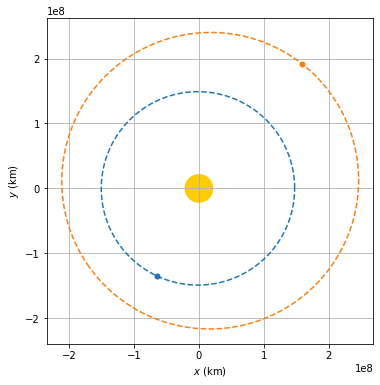

In [27]:
from poliastro.plotting.static import StaticOrbitPlotter

frame = StaticOrbitPlotter()

frame.plot(Orbit.from_body_ephem(Earth))
frame.plot(Orbit.from_body_ephem(Mars))



frame.ax.grid()



In [11]:
x = np.array([(pos[0]*env.nond_l).to(u.km).value for pos in pos_hist])
y = np.array([(pos[1]*env.nond_l).to(u.km).value for pos in pos_hist])
z = np.array([(pos[2]*env.nond_l).to(u.km).value for pos in pos_hist])

In [12]:
import matplotlib.pyplot as plt

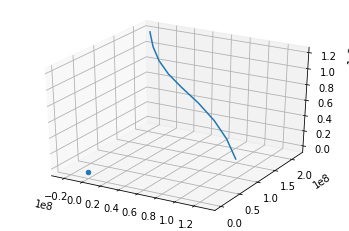

In [13]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.plot3D(x,y,z)
ax.scatter3D([0],[0],[0])